In [1]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [2]:
# Reset pseudo random number generator so that the results are reproducible.
seed = 42
np.random.seed(seed)

### Gerando a função objetivo e sua versão ruidosa.

In [3]:
# Sets the number of examples.
N = 30

# Attribute: uniformly distributed values within the range -1 to +1.
x = np.sort(2*np.random.rand(N, 1) - 1, axis=0)

# Target function.
y = 1 + 0.5*x + 2*(x**2)

# Noise vector.
w = 0.3*np.random.randn(N, 1)

# Noisy function.
y_noisy = y + w

# Generate validation dataset.
Ntest = 100
x_test = np.linspace(-1, 1, Ntest).reshape(Ntest, 1)
y_test = 1 + 0.5*x_test + 2*(x_test**2) + 0.3*np.random.randn(Ntest, 1)

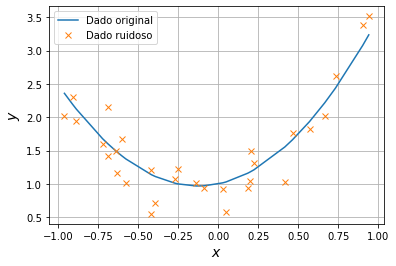

In [4]:
# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#Show the plot.
plt.show()

### Definindo a ordem do polinômio

In [5]:
# Polynomial order.
model_order = 15

### Definindo alguns valores para o fator de regularização, $\lambda$

In [6]:
# Regularization factor.
lambdas = [0, 0.00679, 1]

### Usando a classe Lasso da biblioteca SciKit-Learn

**OBS**.: O parâmetro `alpha` da classe `Lasso` é o fator de regularização, $\lambda$, e não o passo de aprendizagem.

Lambda: 0.0000e+00:
[1.53091512]
[-3.26619148e-01  6.26027965e+00  9.11715885e+00 -8.93092859e+01
 -9.13730327e+01  5.26147653e+02  5.43742416e+02 -1.51291387e+03
 -1.71566113e+03  2.27078228e+03  2.80890380e+03 -1.70290215e+03
 -2.25122856e+03  5.02976634e+02  6.97684255e+02]
---------------------------------------------
Lambda: 6.7900e-03:
[1.53091512]
[ 0.26551456  0.50208083  0.          0.16346725  0.          0.
  0.         -0.          0.         -0.          0.01482161 -0.
  0.0464505  -0.03902626  0.03281059]
---------------------------------------------
Lambda: 1.0000e+00:
[1.53091512]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
---------------------------------------------


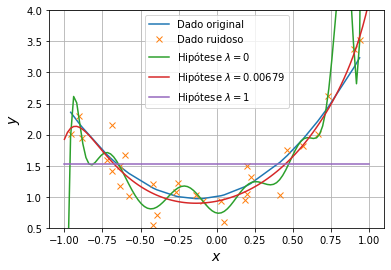

Valor médio: 1.530915117847102


In [7]:
include_bias = True

# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
for i in range(0,len(lambdas)):

    # Instantiate a polynomial with the given degree.
    poly = PolynomialFeatures(degree=model_order, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    scaler = StandardScaler()
    # Instantiate a Lasso regressor.
    # lambda = 0: devido a instabilidades numéricas, a documentação da classe Lasso não recomenda seu uso quando lambda = 0.
    reg = Lasso(alpha=lambdas[i], random_state=seed) if lambdas[i] > 0 else LinearRegression()
    
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])
    
    # Train model.
    model.fit(x, y_noisy)
    
    # Print coefs.
    print('Lambda: %1.4e:' % (lambdas[i]))
    print(model.named_steps['reg'].intercept_)
    if lambdas[i] > 0:
        print(model.named_steps['reg'].coef_[1:model_order+1])
    else:
        print(model.named_steps['reg'].coef_[0, 1:model_order+1])
    print('---------------------------------------------')
    
    # Predict.
    y_test_regul = model.predict(x_test)
    
    # Plot prediction.
    plt.plot(x_test, y_test_regul, label='Hipótese $\lambda=$'+str(lambdas[i]))
    
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.ylim(0.5,4)
#Show the plot.
plt.show()

print('Valor médio:', np.mean(y_noisy))

### Variação dos pesos em função do valor de lambda

In [8]:
include_bias = True

M = 5000
lambdas = np.linspace(1e-3, 1, M)

a_hist = np.zeros((model_order, M))
norm_hist = np.zeros((1, M))
error_test = []

for i in range(0,len(lambdas)):
    # Instantiate a polynomial with the given degree.
    poly = PolynomialFeatures(degree=model_order, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    scaler = StandardScaler()
    # Instantiate a Lasso regressor.
    # max_iter: número de máximo de iterações do gradiente descendente até que ele encerre o treinamento.
    reg = Lasso(alpha=lambdas[i], max_iter=10000, random_state=seed) if lambdas[i] > 0 else LinearRegression()
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)
    a = model.named_steps['reg'].coef_[1:model_order+1]
    a_hist[:,i] = a
    norm_hist[:,i] = np.linalg.norm(a, ord=1)
    # Predict.
    y_test_regul = model.predict(x_test)
    error_test.append((mean_squared_error(y_test, y_test_regul)))

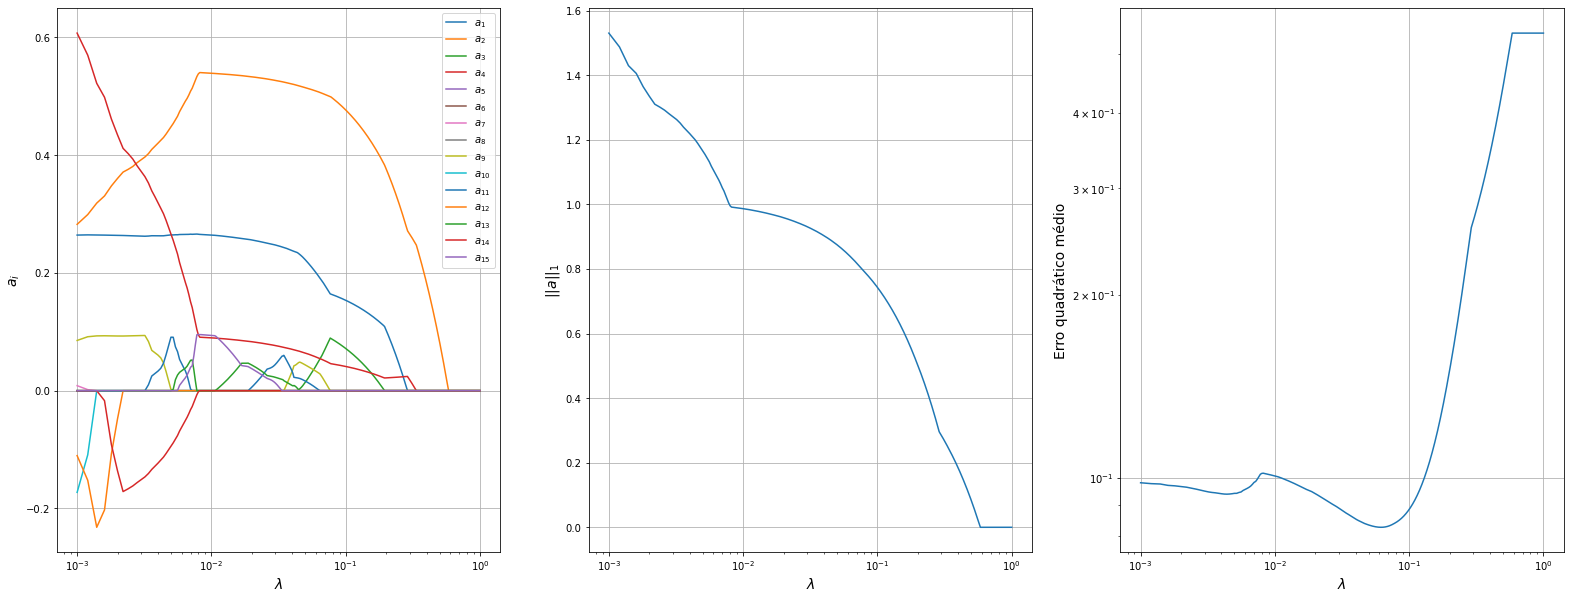

In [9]:
# Create figure.
fig = plt.figure(figsize=(27,10))

# Plot weight.
ax = plt.subplot(1, 3, 1)
for i in range(0,model_order): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$a_i$', fontsize=14)
plt.legend(loc='upper right')
plt.grid()

# Plot norm.
ax = plt.subplot(1, 3, 2)
plt.plot(lambdas, norm_hist[0,:])
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$||a||_1$', fontsize=14)
plt.grid()

# Plot error.
ax = plt.subplot(1, 3, 3)
plt.plot(lambdas, error_test)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('Erro quadrático médio', fontsize=14)
plt.grid()

#Show the plot.
plt.show()

Valores pequenos de $\lambda$ até $1\times10^{-1}$ fazem com que modelo se aproxime da função geradora, após isso, o modelo tende ao valor constante igual à média dos dados de treinamento, o que faz o erro aumentar.

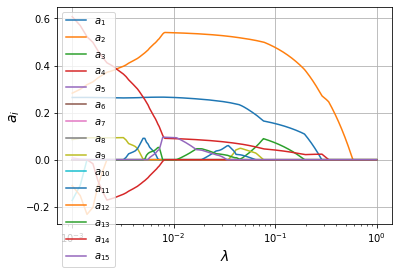

In [10]:
# Plot weight.
for i in range(0,model_order): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$a_i$', fontsize=14)
plt.legend(loc='upper left')
plt.grid()
#Show the plot.
plt.show()

### Usando a classe LassoCV para encontrar o melhor valor de $\lambda$

Vamos usar uma estratégia de busca em um intervalo maior e depois focar a busca em um intervalo em torno do melhor valor encontrado pela busca no intervalo maior.

**Ajuste grosso com escala logarítmica.**

In [11]:
# Define the number of values for lambda.
M = 1000

# Create M values between 10^-5 and 100.
alphas = np.logspace(-3, 2, M)

# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=model_order, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a LassoCV regressor.
reg = LassoCV(alphas=alphas, max_iter=10000, random_state=seed)
# Create a pipeline of actions.
clf = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

# Find the best alpha value.
clf.fit(x, y_noisy.ravel())

print('score:', clf.score(x, y_noisy.ravel()))

score: 0.8815762182871725


In [12]:
clf['reg'].alpha_

0.006773775997517752

**Ajuste fino com escala linear ao redor do valor encontrado pelo ajuste grosso**

Podemos procurar desde valores 5 a 10 vezes menores até 5 a 10 vezes maiores.

In [13]:
# Define the number of values for lambda.
M = 1000

alphas = np.linspace(clf['reg'].alpha_/5, clf['reg'].alpha_*5, M)

# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=model_order, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a LassoCV regressor.
reg = LassoCV(alphas=alphas, max_iter=10000, random_state=seed)
# Create a pipeline of actions.
clf = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

# Find the best alpha value.
clf.fit(x, y_noisy.ravel())

print('score:', clf.score(x, y_noisy.ravel()))

score: 0.8815511948322757


In [14]:
optimum_lambda = clf['reg'].alpha_

print("Best lambda:", optimum_lambda)

Best lambda: 0.0067900493332475245


### Comparação do melhor modelo de aproximação (valor ótimo de $\lambda$) com as versões original e ruidosa.

Agora, de posse do melhor fator de regularização, $\lambda$, treinamos um novo modelo de regressão polinomial com regularização LASSO considerando este valor, calculamos o erro quadrático médio (MSE) e comparamos a predição feita pelo regressor polinomial com regularização LASSO com os dados originais e ruidosos.

MSE: 0.09744501667571213


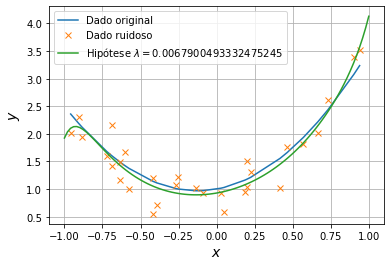

In [15]:
# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=model_order, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a Lasso regressor.
reg = Lasso(alpha=optimum_lambda, random_state=seed)
# Create a pipeline of actions.
clf = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

# Find the best alpha value.
clf.fit(x, y_noisy.ravel())

# Perform prediction.
y_test_pred = clf.predict(x_test)

# Calculating the MSE.
mse = mean_squared_error(y_test, y_test_pred)
print('MSE:', mse)

# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.plot(x_test, y_test_pred, label='Hipótese $\lambda=$'+str(optimum_lambda))
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#Show the plot.
plt.show()

#### Observações:

+ A função polinomial se aproximou razoavelmente bem do modelo gerador.
+ A regularização penalizou alguns pesos, diminuindo a flexibilidade e aumentado o grau de generalização do modelo e, portanto, obtendo um modelo mais próximo do modelo gerador.
+ Portanto, com a regularização, podemos usar um polinômio de alta ordem (ou seja, mais complexo do que o necessário) e mesmo assim aproximarmos a função original. 
+ O uso da regularização com modelos de alta ordem pode ser uma forma de se encontrar um modelo aproximador quando não se tem ideia do grau do modelo gerador.

### Imprimindo os valores dos pesos encontrados pelo modelo de regressão polinomial com regularização LASSO.

In [16]:
clf['reg'].coef_

array([ 0.        ,  0.26551458,  0.50208227,  0.        ,  0.16346449,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.01481956, -0.        ,  0.04645131, -0.03902476,
        0.03281185])

### Conclusões

+ Percebam que vários pesos se tornaram iguais a zero. Isso indica que ocorreu um processo de seleção automática de atributos. + A regressão com regularização L1 (LASSO) tem como característica a produção de modelos esparsos, ou seja, modelos com vários pesos iguais a zero. 
+ Esse processo de seleção automática de atributos leva a modelos menos complexos, ou seja, mais **regulares**.
+ Pesos com valores iguais a zero indicam que os atributos correspondentes são irrelevantes para o processo de regressão e, portanto, podem ser ignorados.
+ Desta forma, podemos desconsiderar (remover) esses termos do polinômio aproximador, pois resultam em valor igual a 0.
+ A vantagem deste novo modelo é que ele evita calculos desnecessários, ou seja, resultaria num modelo computacionalmente menos complexo, pois várias operações de multiplicação e soma seriam evitadas devido a termos com valores nulos.

### Referências

[1] "what is max_iter and tol in Lasso Regularizer sklearn", https://stackoverflow.com/questions/66487819/what-is-max-iter-and-tol-in-lasso-regularizer-sklearn